In [1]:
import sys
import wandb
import torch
from tqdm import tqdm
sys.path.append("..")

%load_ext autoreload
%autoreload 2
import numpy as np
from gym import wrappers
from torch import nn

from matplotlib import pyplot as plt
from src import utils as utils
from src.model import SimpleRecurrent

# torch.autograd.set_detect_anomaly(True)

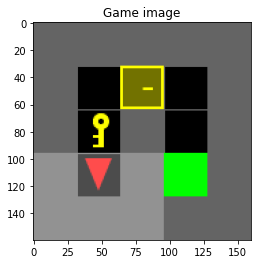

In [2]:
env_name = "MiniGrid-DoorKey-5x5-v0"
# env_name = "MiniGrid-Empty-Random-5x5-v0"
env = utils.make_env(env_name)

obs_space_shape = env.observation_space.shape
n_actions = env.action_space.n

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

In [3]:
from src.a2c import A2CAlgo

LOG_EACH = 30
VIDEO_EACH = 400

config = {
    "time": 4,
    "n_games_mean": 1,
    "max_reward": 2,
    "device": "cpu",
    "env": env_name,
    "hidden_dim": 128,
    "emb_dim": 128,
    "n_env": 128,
    "gamma": 0.99,

    "max_grad_norm": 0.5,
    "lr": 0.001,
    "value_loss_coef": 1,
    "entropy_coef": 0.01,
}


In [4]:

# import os
# os.environ["WANDB_MODE"] = "dryrun"
from src.mlsh_model import MLSHAgent
from src.env_pool import MLSHPool

agent = MLSHAgent(
    1,
    n_actions,
    config
)
agent.master_policy.requires_grad_(False)
for p in agent.parameters():
    nn.init.uniform_(p, -0.1, 0.1)

pool = MLSHPool(agent, lambda : utils.make_env(env_name), config["n_env"])

wandb.init(project="mlsh",
           monitor_gym=True,
           name=f"{env_name[9:]}",
           config=config,
           dir="..",
           magic=True)
wandb.watch(agent)

wandb: Wandb version 0.8.36 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
a2c_subpolicies = \
    A2CAlgo(agent.parameters(),
            config["device"], n_actions,
            config["gamma"],
            config["max_grad_norm"],
            config["entropy_coef"],
            config["lr"],
            config["value_loss_coef"])

In [ ]:
master_step = 5
with torch.no_grad():
    idxs = pool.get_master_idxs()

for i in tqdm(range(4000)):
    rollout_obs, rollout_actions, rollout_rewards, rollout_mask, logits, values = pool.interact(
        config["time"], idxs)
    loss, grad_norm, entropy, values, al, cl = a2c_subpolicies.step(
        rollout_actions, rollout_rewards, rollout_mask, logits, values)
    wandb.log({
            "rew": np.mean(rollout_rewards),
            "values": np.mean(values),
            "policy_loss": al,
            "value_loss": cl
        }, commit=False, step=i)


    if i % LOG_EACH == 0:
        with torch.no_grad():
            reward, step_counter, master_hist = \
                utils.evaluate_mlsh(agent, env, n_games=10, master_step=5)
            reward = np.mean(reward)
            log = {
                "rewards": reward,
                "grad_norm": grad_norm,
                "entropy": entropy,
                "loss": loss
            }
            wandb.log(log, step=i, commit=i%VIDEO_EACH==0)
            if reward  >= config["max_reward"]:
                print("Your agent has just passed the minimum homework threshold")
                break

  0%|          | 0/4000 [00:00<?, ?it/s]wandb: Wandb version 0.8.36 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
 38%|███▊      | 1502/4000 [17:07<1:05:49,  1.58s/it]